In [38]:
%pip install torch torchvision
%pip install opencv-contrib-python
%pip install scikit-learn

# OUR SOURCE : https://blog.paperspace.com/object-localization-pytorch-2/
# Python 3-9

import PIL
import matplotlib as plt
import random


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import argparse
import torch
import time
import PIL


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'leboss'

In [7]:
train, test = train_test_split(pd.read_csv("../../annotation_dataset_formated.csv"),test_size=0.2)
img_dir = "../../dataset/"
print(test)

     filename  ax1  ay1  bx2  by2
83    83.jpeg   67  198   51  175
108  108.jpeg  128  198   93  162
18    18.jpeg  109  198  120  185
74    74.jpeg  115  200  132  178
101  101.jpeg  171  200  185  177
8      8.jpeg   55  199   43  188
57    57.jpeg  133  199  130  179
22    22.jpeg  132  199   79  191
3      3.jpeg  150  197  155  167
35    35.jpeg   59  195   84  186
48    48.jpeg    3  195   54  175
7      7.jpeg   99  196   64  170
73    73.jpeg   95  197  104  176
81    81.jpeg  167  198  141  176
16    16.jpeg  116  198  134  179
43    43.jpeg  127  198  110  189
33    33.jpeg  108  198   92  191
19    19.jpeg  151  198  121  188
93    93.jpeg   99  200  142  178
37    37.jpeg   87  198   46  185
86    86.jpeg  135  200  137  190
0      0.jpeg   62  197   98  172
85    85.jpeg   93  198   88  176


In [10]:
def open_images(paths):
        images = []
        for path in paths:
                with PIL.Image.open(img_dir + path) as image:
                        images.append(np.asarray(image))
                
        return np.array(images)

train_img = open_images(train["filename"])
test_img = open_images(test["filename"])
print(train_img.shape)

(91, 200, 200)


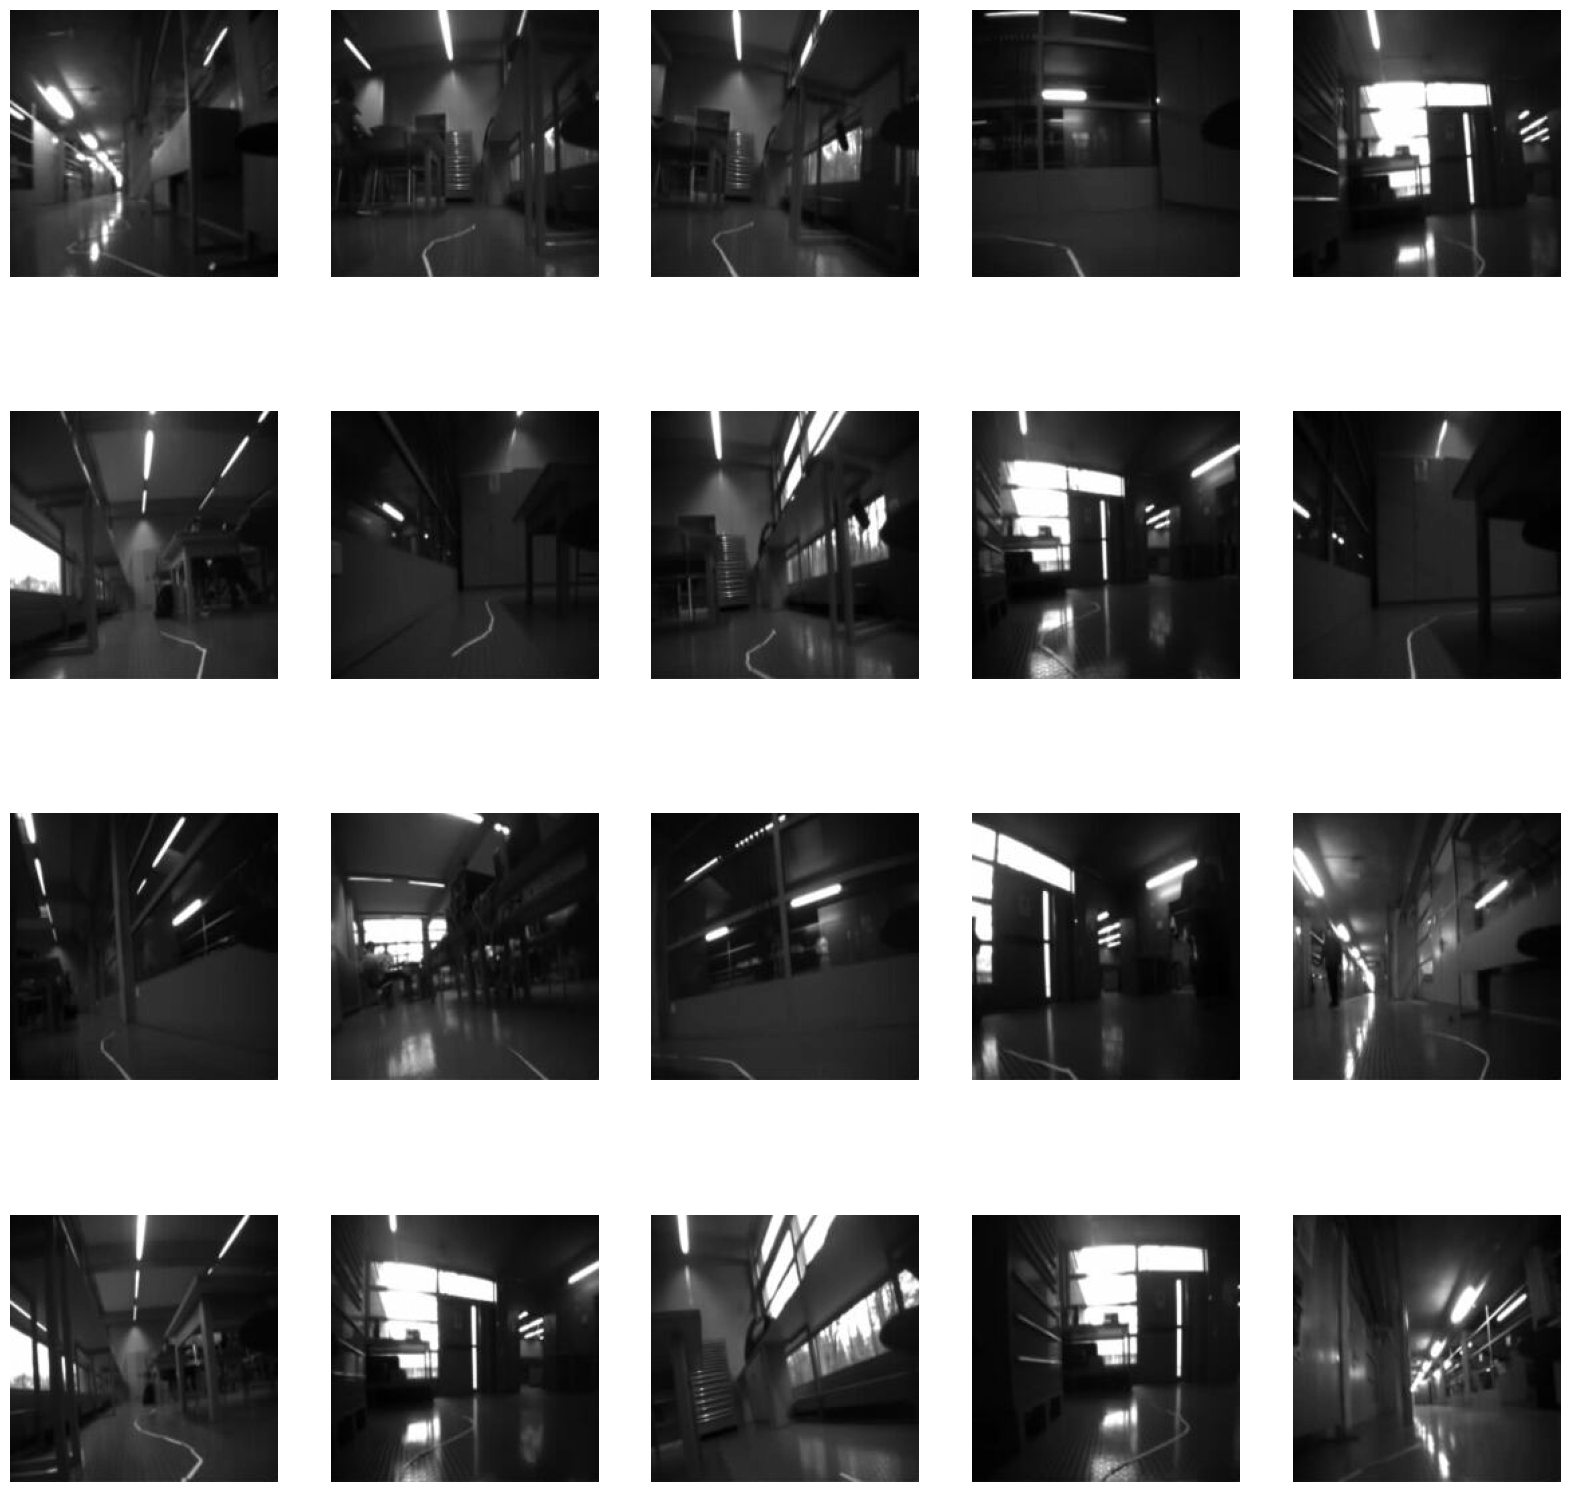

In [14]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20))

# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, len(train_img)), 20)

for itr, i in enumerate(random_range, 1):



    image = train_img[i]


# Clip the values to 0-1 and draw the sample of images
    
    plt.subplot(4, 5, itr)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [35]:
class Dataset():
    def __init__(self, train_images, train_coords):
        self.images = torch.from_numpy(train_images)
        self.coords = torch.from_numpy(train_coords)

    def __len__(self):
        return len(self.coords)

    # To return x,y values in each iteration over dataloader as batches.

    def __getitem__(self, idx):
        return (self.images[idx],
              self.coords[idx])

train_coords = train.loc[:,('ax1','ay1','bx2','by2')].values
test_coords = test.loc[:,('ax1','ay1','bx2','by2')].values

dataset_train = Dataset(train_img,train_coords)
dataset_test = Dataset(test_img,test_coords)


[[ 67 198  51 175]
 [128 198  93 162]
 [109 198 120 185]
 [115 200 132 178]
 [171 200 185 177]
 [ 55 199  43 188]
 [133 199 130 179]
 [132 199  79 191]
 [150 197 155 167]
 [ 59 195  84 186]
 [  3 195  54 175]
 [ 99 196  64 170]
 [ 95 197 104 176]
 [167 198 141 176]
 [116 198 134 179]
 [127 198 110 189]
 [108 198  92 191]
 [151 198 121 188]
 [ 99 200 142 178]
 [ 87 198  46 185]
 [135 200 137 190]
 [ 62 197  98 172]
 [ 93 198  88 176]]


In [41]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
# OUR MODEL 
class BIG_CNN(Module):
	def __init__(self):
		# call the parent constructor
		super(BIG_CNN, self).__init__()

		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=1, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=800, out_features=500)
		self.relu3 = ReLU()
		# initialize our softmax classifier
		self.fc2 = Linear(in_features=500, out_features=4)

	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		# pass the output to get our output
		# predictions
		output = self.fc2(x)
		# return the output predictions
		return output
model = BIG_CNN()
model = model.to(device)
model

BIG_CNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=4, bias=True)
)